## Случайный лес.

Цель этого ноутбука - знакомство со случайными лесами, с их параметрами и свойствами. В ноутбуке будут рассмотрены примеры применения случайного леса для решения задач классификации и регрессии.

In [1]:
import copy
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn import datasets
from sklearn.metrics import accuracy_score, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import warnings

warnings.simplefilter("ignore", DeprecationWarning)
sns.set(context='poster')
%matplotlib inline

### Основные параметры

**Реализации: `RandomForestClassifier`, `RandomForestRegressor`**

Набор гиперпараметров случайного леса очень похож на набор гиперпараметров решающего дерева. Основным отличием является наличие у случайного леса параметра `n_estimators`, задающего количество решающих деревьев, используемых для получения предсказаний. Это **основной гиперпараметр** для случайного леса.

Напомним главные гиперпараметры решающего дерева, которые также имеются у случайного леса.

1) `criterion` -- критерий информативности, по которому происходит разбиение вершины дерева. 

2) `max_depth` -- ограничение на глубину каждого дерева в лесе.

3) `min_samples_split` -- минимальное количество элементов обучающей выборки в вершине дерева, чтобы её можно было разбивать.

4) `min_samples_leaf` -- минимальное количество элементов обучающей выборке в листовой вершине.

5) `splitter` -- способ разбиения вершины каждого решающего дерева. Есть 2 возможных варианта: `best` и `random`. В первом случае рассматриваются все возможные способы разбить вершину дерева на две и берётся тот из них, значение критерия для которого оптимально. При `splitter=random` берётся несколько случайных возможных разбиений и среди них выбирается то, значение критерия для которого оптимально.

6) `max_features` -- максимальное количество признаков, которые могут быть перебраны при разбиении вершины дерева. Перед каждым разбиением дерева генерируется выборка из `min(k, max_features)` случайных признаков (`k` - количество признаков в датасете) и только эти признаки рассматриваются как разделяющие.

7) `min_impurity_split` -- минимальное значение критерия неопределенности (`impurity`) для выборки, попавшей в вершину, чтобы эту выборку можно было разбивать.

О других гиперпараметрах случайного леса можно почитать в документации:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.

# Решение задачи регрессии с помощью Random Forest

Сгенерируем выборку из многомерного нормального распределения и в качестве целевой функции возьмем *расстояние от точки до центра координат*.

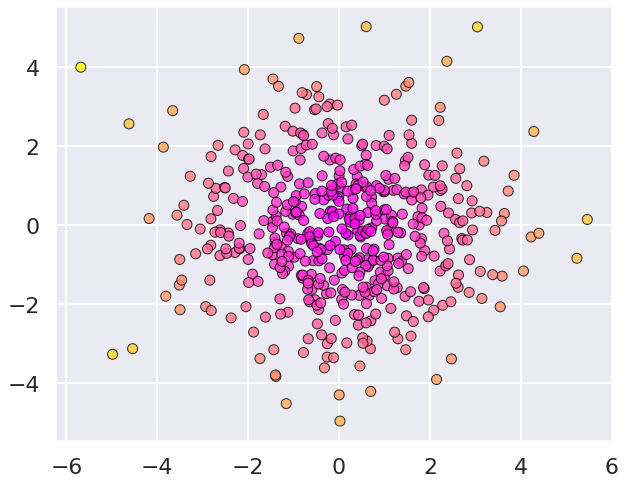

In [2]:
X_train = scipy.stats.multivariate_normal.rvs(
    size=500, mean=[0, 0], cov=[[3, 0], [0, 3]]
)
y_train = (X_train[:, 0] ** 2 + X_train[:, 1] ** 2) ** 0.5

plt.figure(figsize=(10, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='spring', 
            s=100, alpha=0.8, linewidths=1, edgecolors='black')
plt.show()

In [3]:
def generate_grid(sample, border=1, step=0.05):
    ''' Создает сетку на основе выборки для раскраски пространства '''
    
    return np.meshgrid(np.arange(min(sample[:, 0]) - border, 
                                 max(sample[:, 1]) + border, 
                                 step), 
                       np.arange(min(sample[:, 1]) - border, 
                                 max(sample[:, 1]) + border, 
                                 step))


def create_picture(X_train, y_train, model, border=1, step=0.05, 
                   cmap='spring', alpha=1, create_new_figure=True, 
                   figsize=(10, 5), s=100, linewidths=1, points=True):
    '''
    Раскрашивает пространство в соответствии с предсказаниями 
    случайного леса/решающего дерева
    
    Параметры.
    1) X_train - данные обучающей выборки,
    2) y_train - метки обучающей выборки,
    3) model - визуализируемая модель,
    4) border - размер границы между областями пространства, 
       полученными моделью,
    5) step - точность сетки пространства,
    6) cmap - цветовая схема,
    7) aplha - прозрачность точек обучающей выборки,
    8) create_new_figure - флаг, определяющий создавать ли
       новую фигуру,
    9) figsize - размер создаваемой фигуры,
    10) s - размер точек обучающей выборки,
    11) linewidths - размер границы каждой точки,
    12) point - флаг, определяющий, отображать ли точки
        обучающей выборки на графике.
    '''
    
    # Создание сетки
    grid = generate_grid(X_train, border, step)
    # Выворачивание сетки для применения модели
    grid_ravel = np.c_[grid[0].ravel(), grid[1].ravel(0)]
    
    # Предсказание значений для сетки
    grid_predicted_ravel = model.predict(grid_ravel)
    grid_predicted = grid_predicted_ravel.reshape(grid[0].shape)  # Подгоняем размер
    
    
    # Построение фигуры
    if create_new_figure:
        plt.figure(figsize=figsize)
        
    plt.pcolormesh(grid[0], grid[1], grid_predicted, cmap=cmap)
    if points:
        plt.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, s=s, 
            alpha=alpha, cmap=cmap, linewidths=linewidths, edgecolors='black'
        )
    plt.xlim((min(grid_ravel[:, 0]), max(grid_ravel[:, 0])))
    plt.ylim((min(grid_ravel[:, 1]), max(grid_ravel[:, 1])))
    plt.title('max_depth = ' + str(model.get_params()['max_depth']))
    
    if create_new_figure:
        plt.show()

### Визуализация предсказания решающими деревьями с различным значением максимальной глубины

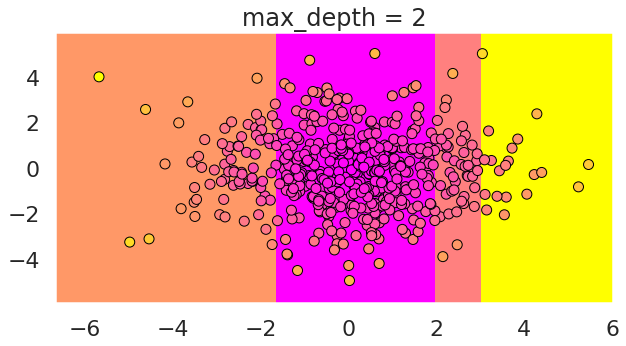

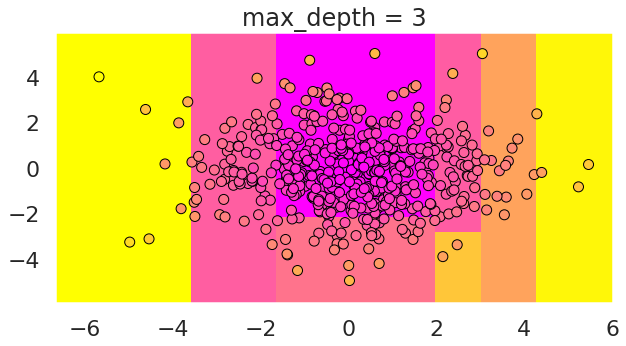

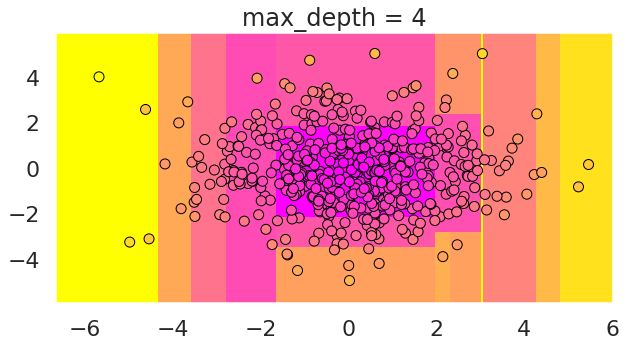

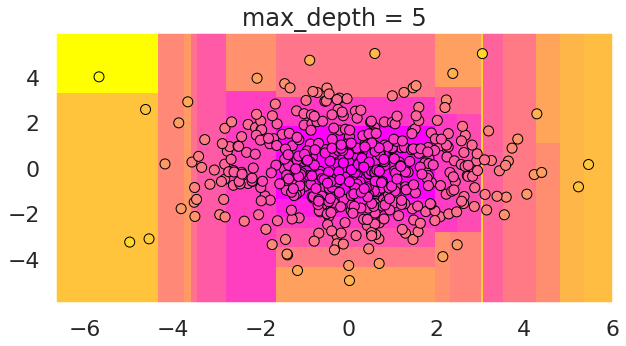

In [4]:
for max_depth in range(2, 6):
    create_picture(X_train, y_train, 
                   DecisionTreeRegressor(max_depth=max_depth).fit(X_train, y_train))

### Визуализация предсказаний случайного леса

Обучим случайный лес на 35 деревьев (для удобства визуализации)

In [5]:
n_estimators = 35
model = RandomForestRegressor(n_estimators=n_estimators)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=35,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Визуализация предсказания по каждому из деревьев по отдельности.
Они все такие разные и такие переобученные...

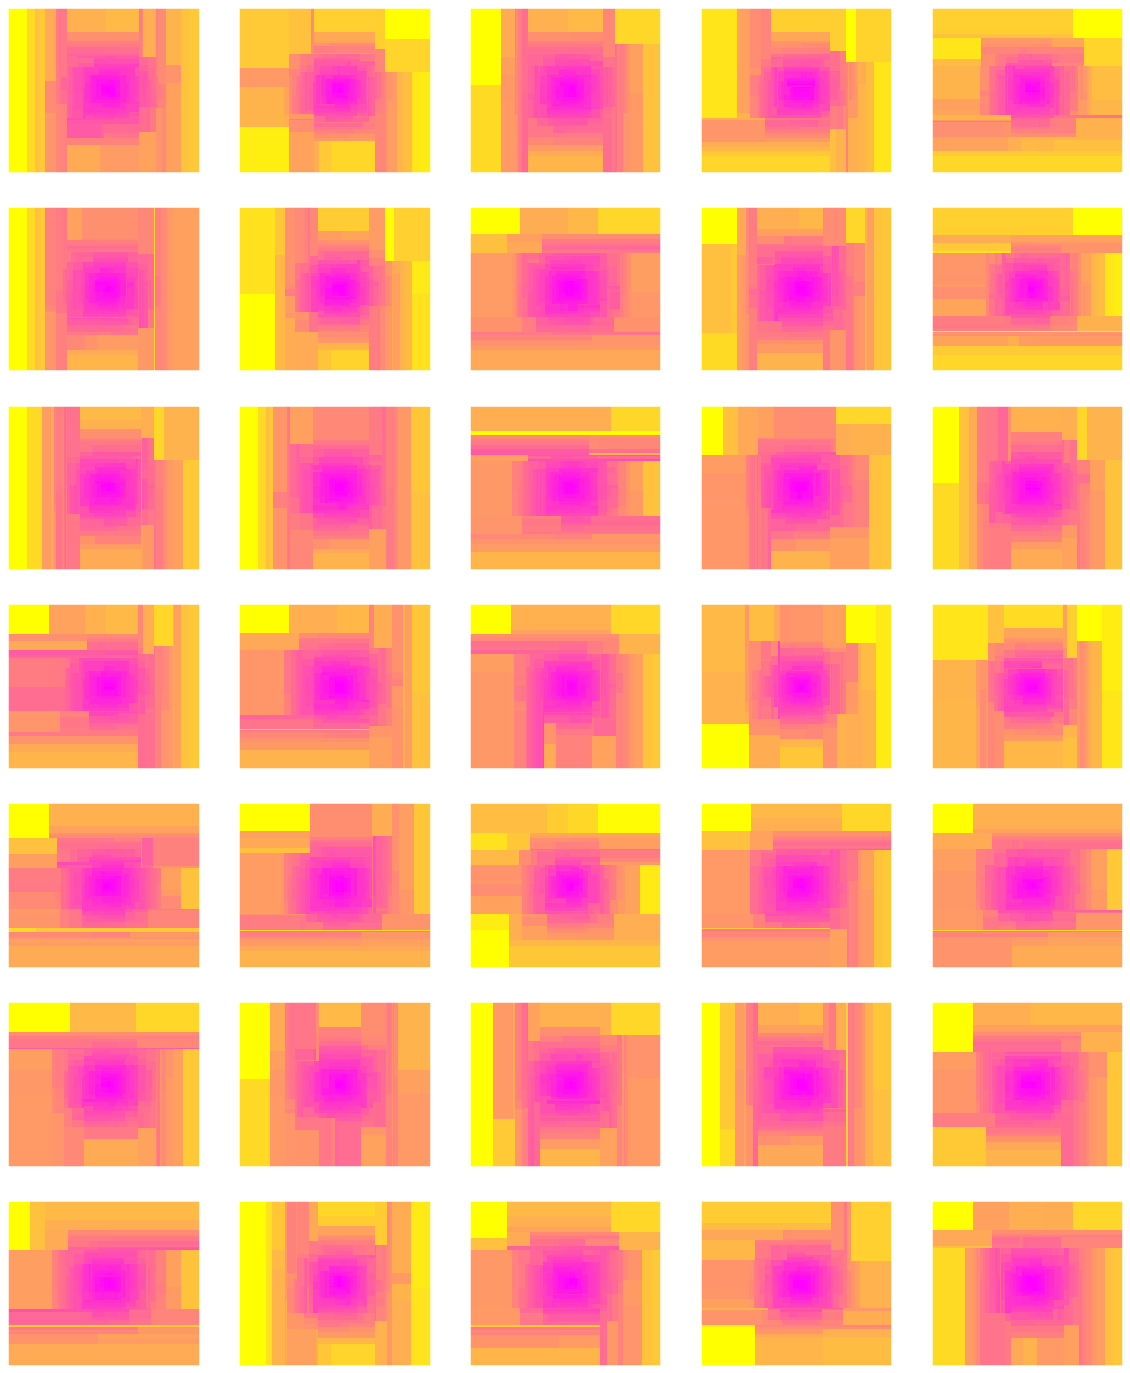

In [6]:
plt.figure(figsize=(20, 25))
for i in range(n_estimators):
    plt.subplot(np.floor(n_estimators / 5), 5, i+1)
    create_picture(X_train, y_train, model.estimators_[i], 
                   create_new_figure=False, s=20, linewidths=0, points=False)
    plt.title('')
    plt.xticks([]), plt.yticks([])

Усредненное предсказание

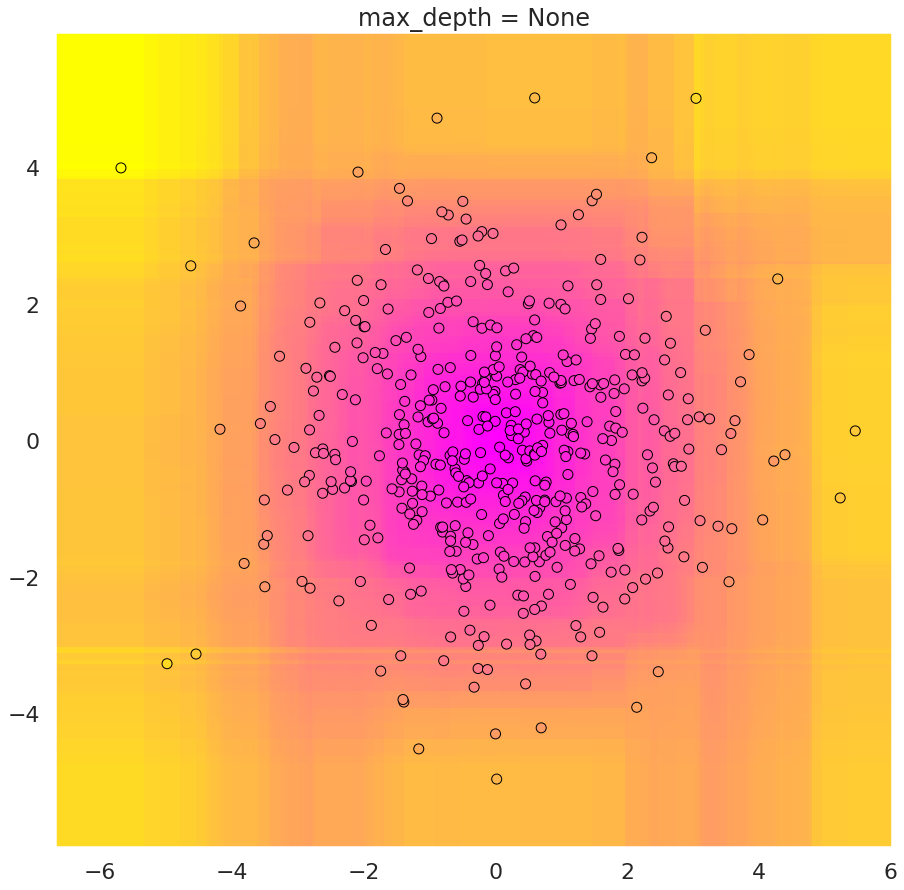

In [7]:
create_picture(X_train, y_train, model, figsize=(15, 15))

То же самое с 100 деревьями

In [8]:
n_estimators = 100
model = RandomForestRegressor(n_estimators=n_estimators)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

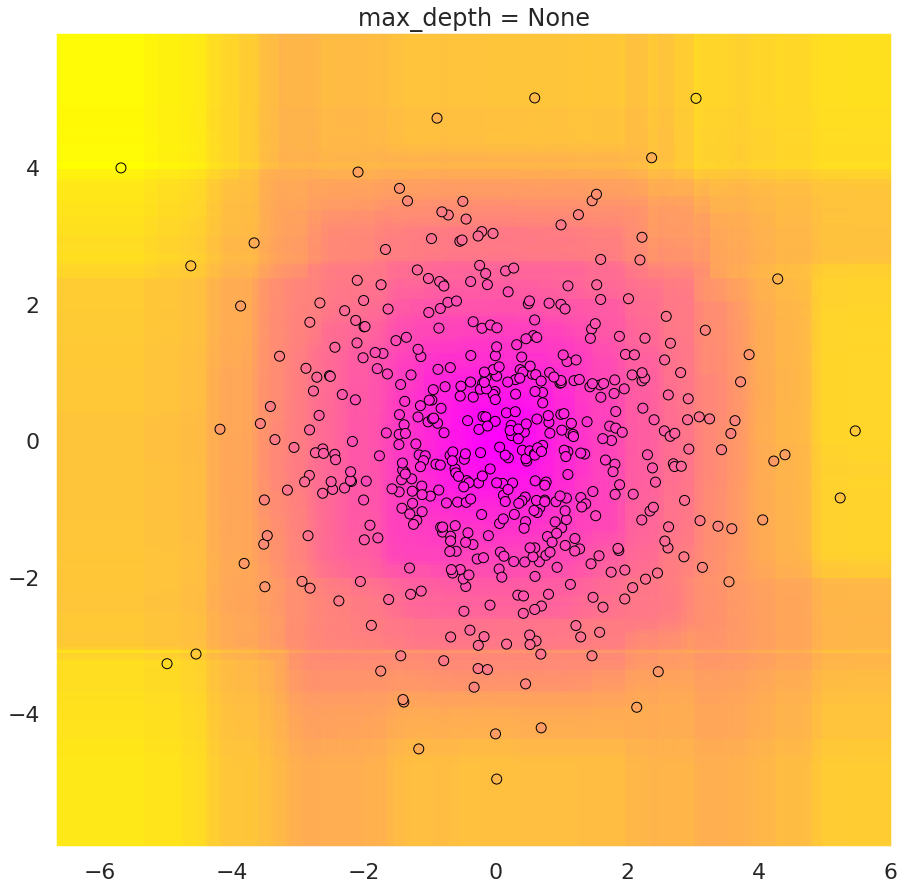

In [9]:
create_picture(X_train, y_train, model, figsize=(15, 15))

### Зависимость  качества предсказаний леса от `n_estimators`

Создадим тестовую выборку

In [10]:
X_test = scipy.stats.multivariate_normal.rvs(
    size=1000, mean=[0, 0], cov=[[3, 0], [0, 3]]
)
y_test = (X_test[:, 0] ** 2 + X_test[:, 1] ** 2) ** 0.5

In [11]:
def cum_metric(model, metric, x_test, y_test):
    ''' 
    Считает значение метрики в зависимости от количества деревьев в модели
    
    Параметры.
    1) model - модель случайного леса,
    2) metric - вычисляемая метрика,
    3) x_test - данные тестовой выборки,
    4) y_test - метки тестовой выборки.
    '''
    
    predictions_by_estimators = [est.predict(x_test) for est in model.estimators_]
    cumpred = np.array(predictions_by_estimators).cumsum(axis=0) \
              / (np.arange(len(predictions_by_estimators)) + 1)[:, np.newaxis]
    cumacc = [metric(y_test, pred) for pred in cumpred]
    return np.array(cumacc)

Визуализируем значение метрики MSE в зависимости от количества деревьев в модели.
Поскольку каждая модель является случайной, **проведем обучение 1000 раз** и усредним значения метрики.
На графике также нарисуем полупрозрачными кривыми зависимость MSE от количества деревьев для каждой модели.

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


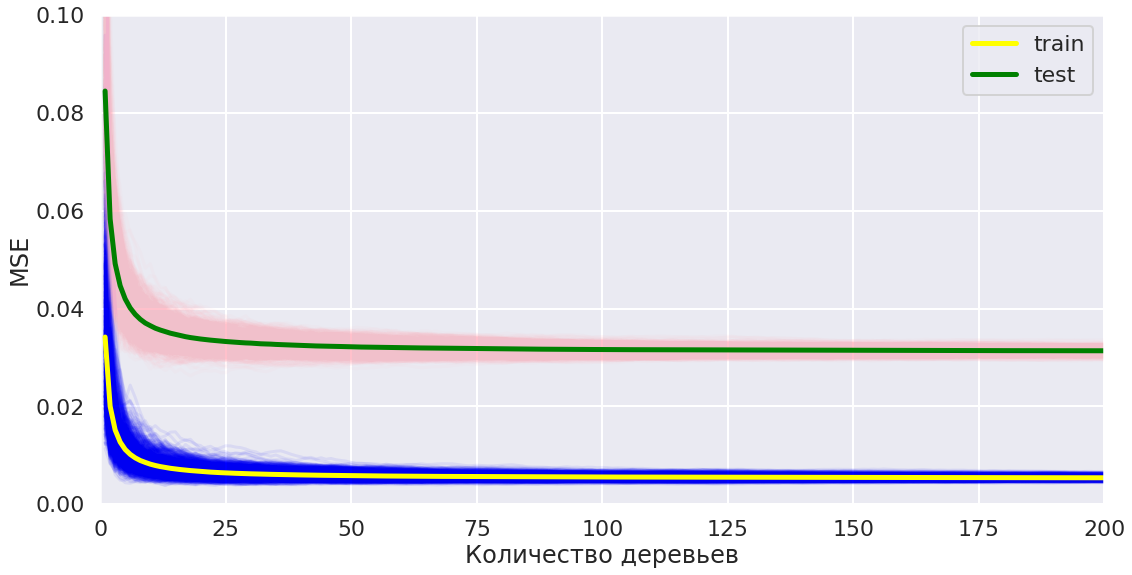

CPU times: user 6min 57s, sys: 1.23 s, total: 6min 58s
Wall time: 6min 58s


In [12]:
%%time

n_iterations = 1000
n_estimators = 200
scores_train = np.zeros((n_iterations, n_estimators))
scores_test = np.zeros((n_iterations, n_estimators))
estrimator_range = np.arange(n_estimators) + 1

plt.figure(figsize=(18, 9))

for i in tqdm_notebook(range(n_iterations), leave=False):
    rf = RandomForestRegressor(n_estimators=n_estimators).fit(X_train, y_train)
    scores_train[i] = cum_metric(rf, mean_squared_error, X_train, y_train)
    scores_test[i] = cum_metric(rf, mean_squared_error, X_test, y_test)
    plt.plot(estrimator_range, scores_train[i], color='blue', alpha=0.07)
    plt.plot(estrimator_range, scores_test[i], color='pink', alpha=0.07)

plt.plot(estrimator_range, scores_train.mean(axis=0), 
         lw=5, color='yellow', label='train')
plt.plot(estrimator_range, scores_test.mean(axis=0), 
         lw=5, color='green', label='test')
plt.xlabel('Количество деревьев'), plt.ylabel('MSE')
plt.xlim((0, 200)), plt.ylim((0, 0.1))
plt.legend()
plt.show()

Как видим, с увеличением количества деревьев в среднем ошибка монотонно убывает как на обучающей выборке, так и на тестовой. Иначе говоря, **в среднем случайный лес не переобучается** при увеличении количества деревьев. Можно взять миллион деревьев, и плохо от этого скорее всего не станет. Для конкретной реализации случайности может возникнуть некоторое переобучение, например, если в начале построения композиции попадутся "удачные" деревья, то при последующем добавлении деревьев ошибка может вырасти.

### Зависимость  качества предсказаний леса от значений гиперпараметров

Теперь исследуем зависимость качества предсказаний случайного леса от значений гиперпараметров. Рассмотрим датасет `diabetes` из `sklearn`. В нём исследуется численная оценка прогрессирования диабета у пациентов на основе таких признаков, как возраст, пол, масса тела, среднее кровяное давление и некоторых других. Для того, чтобы лучше понять, что из себя представляют признаки в этом датасете, можно обратиться к этой странице: https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html.

In [13]:
diabetes = datasets.load_diabetes() 
X = diabetes.data
y = diabetes.target

In [14]:
print('data shape:', X.shape)
print('target shape:', y.shape)

data shape: (442, 10)
target shape: (442,)


Как и в предыдущих экспериментах, разобьём данные на обучение и тест.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Подберём оптимальные параметры для `RandomForestRegressor` по сетке.

In [16]:
tree_gridsearch = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid={
        'max_depth': [3, 5, None], 
        'n_estimators': [5, 10, 25, 50],
        'min_samples_leaf': [1, 2, 5], 
        'min_samples_split': [2, 5]
    }
)

In [17]:
tree_gridsearch.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 5, None],
 

In [18]:
print(tree_gridsearch.best_params_)

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 25}


Посчитаем значение метрики `r2-score`.

In [19]:
print('train r2_score {:.4f}'.format(
    r2_score(tree_gridsearch.best_estimator_.predict(X_train), y_train)
))
print('test r2_score {:.4f}'.format(
    r2_score(tree_gridsearch.best_estimator_.predict(X_test), y_test)
))

train r2_score 0.3934
test r2_score -0.0593


Теперь попробуем резко увеличить значение `min_samples_leaf`.

In [20]:
regressor = RandomForestRegressor(random_state=42, min_samples_leaf=20, 
                                  n_estimators=25, max_depth=5)
regressor.fit(X_train, y_train)

print('train r2_score {:.4f}'.format(
    r2_score(regressor.predict(X_train), y_train)
))
print('test r2_score {:.4f}'.format(
    r2_score(regressor.predict(X_test), y_test)
))

train r2_score -0.0840
test r2_score -0.0908


**Вывод.**

Заметим, что значение `r2_score` снизилось как на обучающей, так и на тестовой выборке. Это значит, что модель с таким ограничением на минимальное количество элементов в личтовой вершине недообучена и плохо улавливает закономерности в данных.

Теперь попробуем, наоборот, сделать значение `min_samples_leaf` меньше оптимального.

In [21]:
regressor = RandomForestRegressor(random_state=42, min_samples_leaf=3, 
                                  n_estimators=25)
regressor.fit(X_train, y_train)

print('train r2_score {:.4f}'.format(
    r2_score(regressor.predict(X_train), y_train)
))
print('test r2_score {:.4f}'.format(
    r2_score(regressor.predict(X_test), y_test)
))

train r2_score 0.6997
test r2_score -0.1002


**Вывод.**

Видно, что значение `r2_score` на обучающей выборке выросле, а на валидационной - упало. Значит, лес немного переобучился.

# Решение задачи классификации с помощью Random Forest

Теперь проделаем похожие эксперименты для задачи классификации. Возьмём датасет для распознавания латинских букв на изображениях https://archive.ics.uci.edu/ml/datasets/Letter+Recognition.
     
Некотрые из признаков, содержащихся в датасете:
1.	`lettr` - заглавная буква	(принимает значения от A до Z);
2.	`x-box` - горизонтальная позиция прямоугольника с буквой;
3.	`y-box` - вертикальная позиция прямоугольника с буквой;
4.	`width`	- ширина прямоугольника;
5.	`high` - высота прямоугольника;
6.	`onpix` - количество пикселей, относящихся к цифре;
7. `x-bar` - среднее значение x всех пикселей в прямоугольнике;
8. `y-bar` - среднее значение y всех пикселей в прямоугольнике;
9. `x2-bar` - выборочная дисперсия x;
10. `y2-bar` - выборочная дисперсия y;
11. `xybar` - корреляция x и y.

In [22]:
letters_df = pd.read_csv('letter-recognition.data', header=None)
print('dataset shape:', letters_df.shape)
letters_df.head()

dataset shape: (20000, 17)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [23]:
X = letters_df.values[:, 1:]
y = letters_df.values[:, 0]

### Зависимость точности классификации от значений гиперпараметров

Разобьём данные на обучающую и тестовую выборки.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Для начала попробуем оценить оптимальное количество решающих деревьев в лесе, взяв значения всех остальных параметров по умолчанию. Построим график зависимости `accuracy` от `n_estimators` на обучающей и на тестовой выборках. В большинстве случаев, значение `n_estimators` берут в диапазоне от 10 до 100. Но здесь мы рассмотрим боее широкий набор значений - от 1 до 200.

In [25]:
def get_train_and_test_accuracy(param_name, grid, other_params_dict={}):
    '''
    Функция для оценки точности классификации 
    для заданных значений параметра param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра,
    3) other_params_dict - словарь со значениями остальных параметров.
    '''
        
    train_acc, test_acc = [], []
    params_dict = copy.copy(other_params_dict)
    
    for param_value in grid:
        params_dict.update({param_name: param_value})
        estimator = RandomForestClassifier(**params_dict, random_state=42)
        estimator.fit(X_train, y_train)
        train_acc.append(accuracy_score(y_train, estimator.predict(X_train)))
        test_acc.append(accuracy_score(y_test, estimator.predict(X_test)))
    return train_acc, test_acc

In [26]:
def plot_dependence(param_name, grid=range(2, 20), 
                    other_params_dict={}, title=''):
    '''
    Функция для отображения графика зависимости accuracy 
    от значения параметра c названием param_name
    
    Параметры:
    1) param_name - название параметра, который собираемся варьировать,
    2) grid - сетка значений параметра,
    3) other_params_dict - словарь со значениями остальных параметров,
    4) title - заголовок графика.
    '''
    
    plt.figure(figsize=(12, 6))
    
    train_acc, test_acc = get_train_and_test_accuracy(
        param_name, grid, other_params_dict
    )
        
    plt.plot(grid, train_acc, label='train')
    plt.plot(grid, test_acc, label='test')
    plt.legend(fontsize=14)
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.title(title, fontsize=20)
    plt.show()

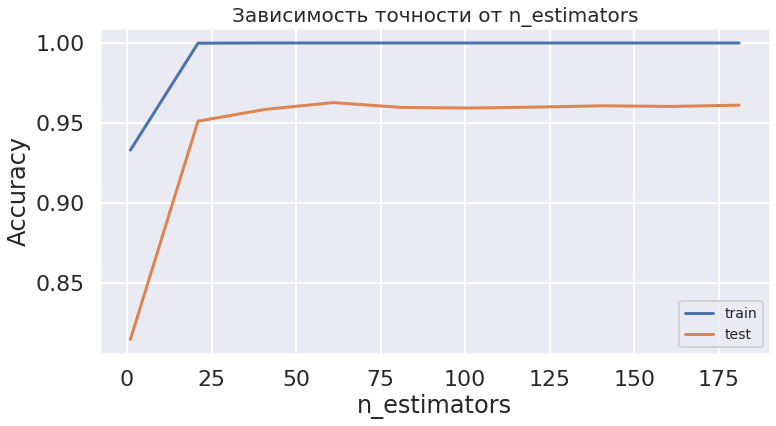

In [27]:
plot_dependence(
    'n_estimators', range(1, 200, 20),
    title='Зависимость точности от n_estimators'
)

Как можно заметить, при `n_estimators` > 75 заметных изменений в `accuracy` как на обучающей, так и на тестовой выборке не происходит. В теории, при предположении, что все решающие деревья в лесе независимы между собой, должно получаться, что при увеличении числа случайных решающих деревьев в лесе дисперсия предсказания монотонно снижается, а точность монотонно повышается. Однако из-за того, что на практике решающие деревья попарно скоррелированны, такой эффект наблюдается лишь до некоторого значения `n_estimators`, а затем значительных изменений не происходит.

Теперь зафиксируем `n_estimators`=75 и будем использовать это значение во всех последующих экспериментах с данным датасетом. Построим график зависимости `accuracy` от `min_samples_leaf` на обучающей и на тестовой выборках.

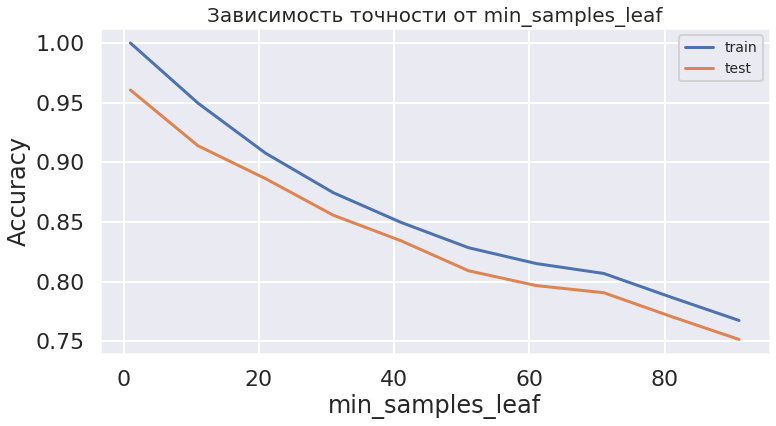

In [28]:
plot_dependence(
    'min_samples_leaf', range(1, 100, 10), {'n_estimators': 75},
    title='Зависимость точности от min_samples_leaf'
)

**Вывод.**

В целом наблюдается следующая закономерность: с увеличением значения `min_samples_leaf` падает качество и на обучающей и на тестовой выборке. Напомним, что при использовании одного решающего дерева закономерность была иной: до некоторого значения `min_samples_leaf` качество на тестовой выборке повышалось. Такая разница в поведении связана с тем, что при увеличении `min_samples_leaf` понижается дисперсия предсказаний, но повышается их смещенность. Если в одиночном решающем дереве такой способ понижения дисперсии мог приносить положительные результаты, то при использовании случайного леса это теряет смысл.

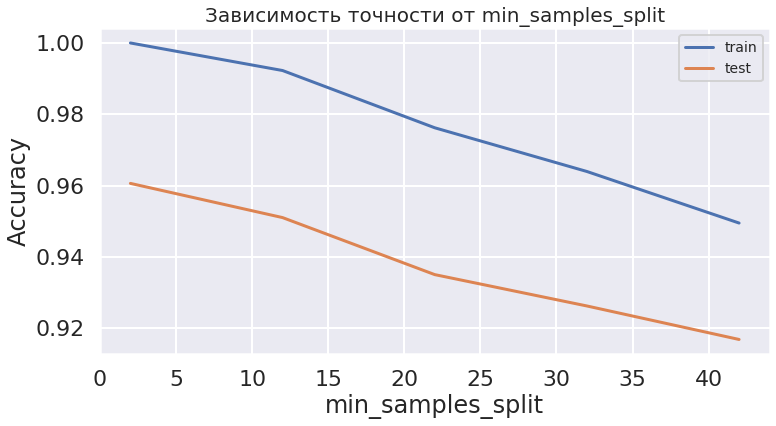

In [29]:
plot_dependence(
    'min_samples_split', range(2, 50, 10), {'n_estimators': 75},
    title='Зависимость точности от min_samples_split'
)

**Вывод.**

При повышении значения `min_samples_split` происходит то же, что и при повышении `min_samples_leaf`.

А теперь найдём оптимальный набор гиперпараметров и использованием кросс-валидации. 
Зададим сетку для подбора параметров и сделаем кросс-валидацию с 5 фолдами (значение по умолчанию).

In [30]:
tree_gridsearch = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        'n_estimators': [10, 50, 75, 100], 'max_depth': [2, 5, None],
        'min_samples_leaf': [1, 2, 5, 10]
    }
)

In [31]:
tree_gridsearch.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

Выведем оптимальные параметры.

In [32]:
print(tree_gridsearch.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}


In [33]:
print('train accuracy:', accuracy_score(tree_gridsearch.best_estimator_.predict(X_train), y_train))
print('test accuracy:', accuracy_score(tree_gridsearch.best_estimator_.predict(X_test), y_test))

train accuracy: 1.0
test accuracy: 0.958


Получилось довольно неплохое качество предсказания. 
Заметим ещё одну особенность подбора оптимальных гиперпараметров для случайного леса. Как вы помните, при использовании решающего дерева было довольно полезно ограничить его максимальную глубину. И, когда мы находили по кросс-валидации оптимальные гиперпараметры для одного решающего дерева, оптимальное значение `max_depth` не превосходило 5. В случае со случайным лесом оптимально вообще не ограничивать глубину решающего дерева, так как в таком случае деревья получаются менее смещёнными, а попарная корреляция между ними становится меньше. 